In [1]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import sys
sys.path.append('../')
from cnn.commons import full_inference_e2e, inc_inference_e2e, adaptive_drilldown, generate_heatmap
from cnn.imagenet_classes import class_names
from cnn.vgg16 import VGG16

image_file_path = "../cnn/dog_resized.jpg"
interested_logit_index = 208

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
patch_size = 16
stride = 1

In [3]:
# torch.cuda.synchronize()
prev_time = time.time()
x = full_inference_e2e(VGG16, image_file_path, patch_size, stride, interested_logit_index, batch_size=128)
torch.cuda.synchronize()
full_inference_time = time.time() - prev_time
print("Full Inference Time: " + str(full_inference_time))

../cnn/commons.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  orig_image = Variable(loader(orig_image).unsqueeze(0), volatile=True)


Full Inference Time: 126.47667408


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


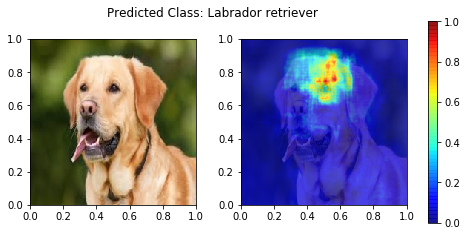

In [4]:
orig_hm = generate_heatmap(image_file_path, x, show=True, label=class_names[interested_logit_index])

output = open('temp', 'w')
pickle.dump(orig_hm, output)

In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
def inc_inference(beta, patch_size=4, stride=1, adaptive=False):
    torch.cuda.synchronize()
    if not adaptive:
        x = inc_inference_e2e(VGG16, image_file_path, patch_size, stride, interested_logit_index,
                                  batch_size=1024, beta=beta)
    else:
        x = adaptive_drilldown(VGG16, image_file_path, patch_size, stride, interested_logit_index,
                                    batch_size=1024, beta=beta, percentile=20)
    
    torch.cuda.synchronize()

    return x

### Patch growth thresholding

BETA: 1.0 Inference Time: 24.1457049847


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


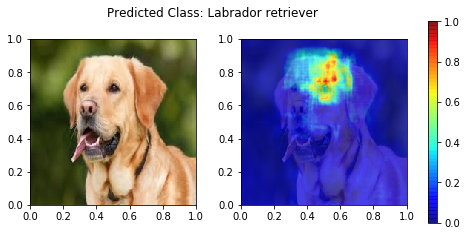

BETA: 0.7 Inference Time: 20.5186140537


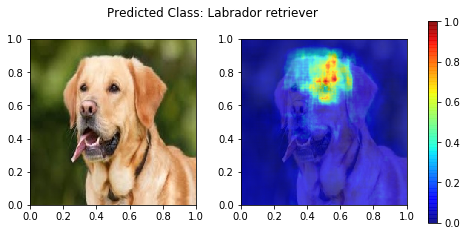

BETA: 0.5 Inference Time: 20.727230072


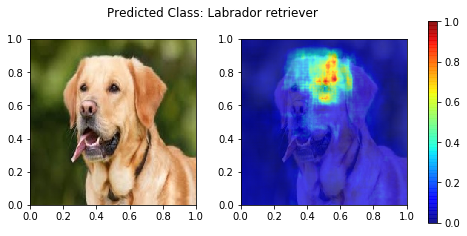

BETA: 0.4 Inference Time: 18.8056268692


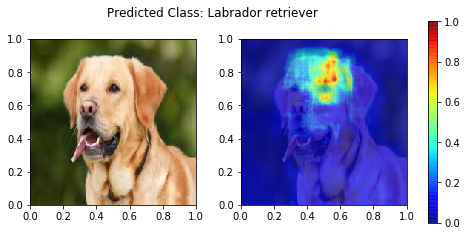

BETA: 0.35 Inference Time: 16.6705861092


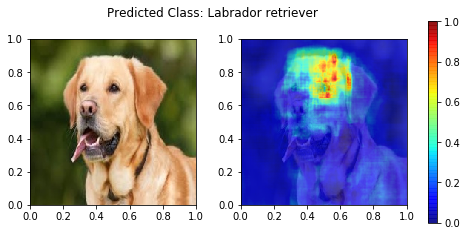

BETA: 0.3 Inference Time: 14.8568539619


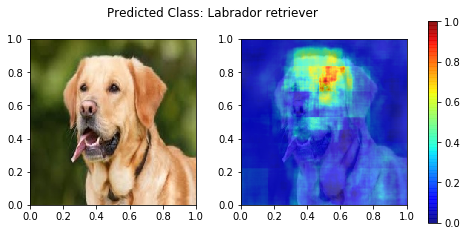

BETA: 0.25 Inference Time: 16.3272180557


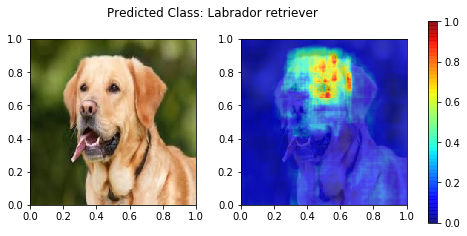

BETA: 0.2 Inference Time: 14.0927760601


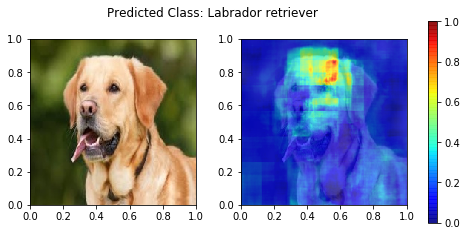

In [5]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

for beta in [1.0, 0.7, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2]:
    prev_time = time.time()
    x = inc_inference(beta, patch_size=patch_size, stride=stride)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, label=class_names[interested_logit_index])
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True))

Text(0,0.5,'SSIM')

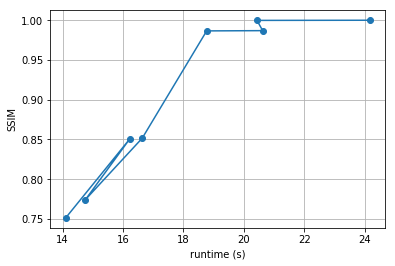

In [5]:
plt.plot(times, score, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('SSIM')

BETA: 1.0 Inference Time: 15.6501471996


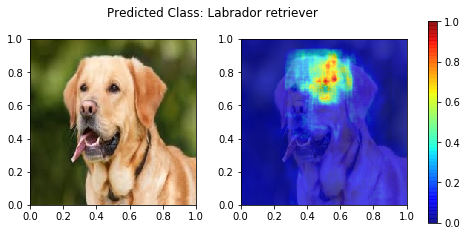

BETA: 0.7 Inference Time: 14.9835591316


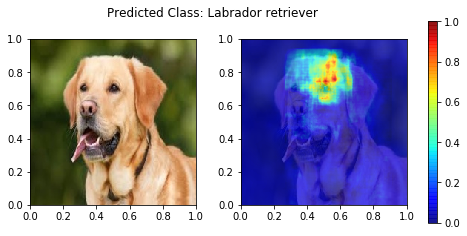

BETA: 0.5 Inference Time: 13.9982860088


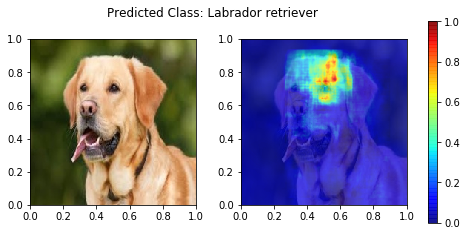

BETA: 0.4 Inference Time: 12.4076178074


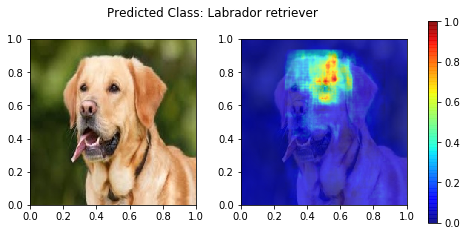

BETA: 0.35 Inference Time: 12.2317800522


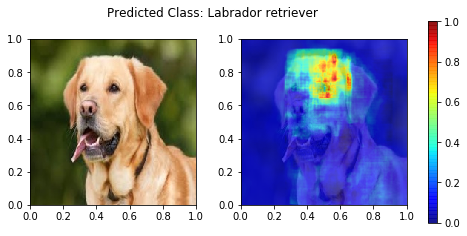

BETA: 0.3 Inference Time: 11.6277508736


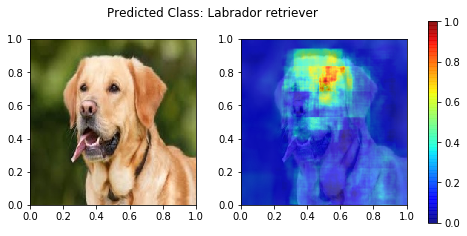

BETA: 0.25 Inference Time: 11.9389660358


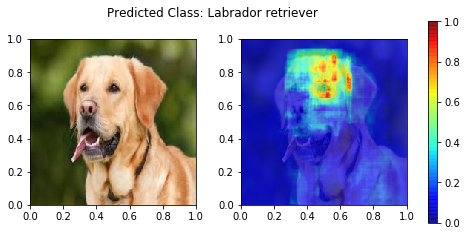

BETA: 0.2 Inference Time: 11.1496100426


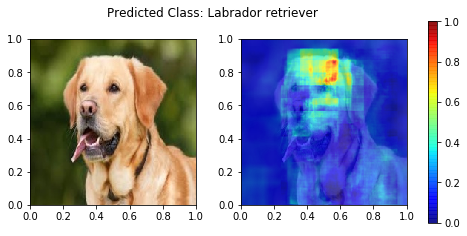

In [6]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

for beta in [1.0, 0.7, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2]:
    prev_time = time.time()
    x = inc_inference(beta, patch_size=patch_size, stride=stride, adaptive=True)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, label=class_names[interested_logit_index])
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True))

Text(0,0.5,'SSIM')

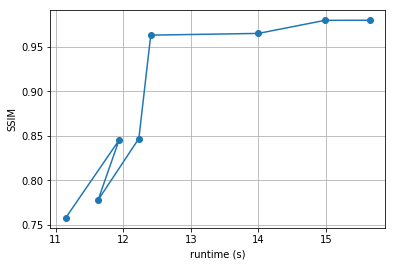

In [7]:
plt.plot(times, score, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('SSIM')